# Time-Series Forecasting: Predicting Stock Prices Using Facebook’s Prophet Model

* Ref: [https://getpocket.com/redirect?url=https%3A%2F%2Ftowardsdatascience.com%2Ftime-series-forecasting-predicting-stock-prices-using-facebooks-prophet-model-9ee1657132b5](https://getpocket.com/redirect?url=https%3A%2F%2Ftowardsdatascience.com%2Ftime-series-forecasting-predicting-stock-prices-using-facebooks-prophet-model-9ee1657132b5)
* Data: TSLA.csv

* Prophet 用的是 additive regression model
  * $y(t) = g(t) + s(t) + h(t) + e(t)$
    * $g(t)$: trend
    * $s(t)$: seasonality 或 periodicity
    * $h(t)$: holiday
    * $e(t)$: error
* Prophet 可以處理 missing values 和 outliers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [3]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,262.220001,263.000000,257.820007,259.149994,259.149994,2610900
1,2015-07-13,262.250000,262.549988,256.049988,262.160004,262.160004,2960300
2,2015-07-14,262.100006,265.989990,260.510010,265.649994,265.649994,1907600
3,2015-07-15,266.739990,267.489990,262.079987,263.140015,263.140015,2021600
4,2015-07-16,264.220001,267.200012,263.160004,266.679993,266.679993,1616000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,322.970620,329.416704,316.361509,323.210302,323.210302,7.958392e+06
std,167.003785,172.289663,161.543065,167.593710,167.593710,5.857375e+06
min,142.320007,154.970001,141.050003,143.669998,143.669998,7.080000e+05
25%,229.310005,232.125000,225.315002,229.434998,229.434998,4.316150e+06
50%,283.829987,289.440002,278.880005,284.730011,284.730011,6.162600e+06
75%,339.809998,345.195007,333.680007,338.949997,338.949997,9.316800e+06
max,1405.010010,1429.500000,1351.280029,1394.280029,1394.280029,6.093880e+07


* 只看 `Close` 欄位
* 把欄位名字改成 prophet 吃的格式
  * 時間的欄位要叫做 ds
  * 數值的欄位要叫做 y

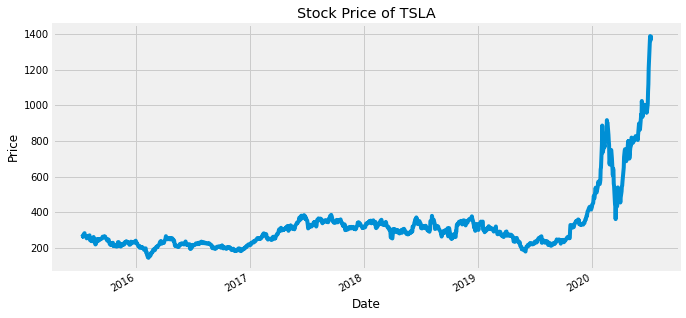

In [7]:
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(10, 5))
df['Close'].plot(ax=ax)
ax.set_ylabel('Close Stock Price')
ax.set_title('Stock Price of TSLA')
plt.show()

In [8]:
# 剛剛為了畫圖方便，把 Date 欄位變成了 DatetimeIndex 了
# 這邊要把 Date 變回普通欄位，然後再改名字
df.reset_index(inplace=True)

df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df.head()

,ds,y
0,2015-07-10,259.149994
1,2015-07-13,262.160004
2,2015-07-14,265.649994
3,2015-07-15,263.140015
4,2015-07-16,266.679993


## 2. Analysis

* 可以檢查 stationarity，不過 Prophet 似乎沒有要求 time series 是 stationary 的

## 3. Forecast

* 這邊不要把 data 分成 train 和 test datasets 了，把全部都拿來 train，然後直接預測未來的結果
* [https://github.com/facebook/prophet](https://github.com/facebook/prophet)

In [10]:
from fbprophet import Prophet
# 用 95% confidence level (預設好像是 80%)
model = Prophet(daily_seasonality = True, interval_width=0.95)

# fit the model using all data 所以把整個 df 餵進去
model.fit(df)

# 要建立一個有未來日期的 dataframe 餵給 prophet
# df_future 包含了所有 df 內的日期，並且在多延伸出 365 time step
df_future = model.make_future_dataframe(periods=365) # 預測未來一整年的股價走勢
display(df_future.head())

print(len(df), len(df_future), len(df_future) - len(df))

# 做預測
predictions = model.predict(df_future)
display(predictions.head())

# predictions 有很多欄位，實際上我目前只會需要 ds, yhat, yhat_lower, yhat_upper
# 但是不能直接選出這幾個欄位就好，因為如果要用 model 的方法來畫圖時，會需要其他欄位的資訊

,ds
0,2015-07-10
1,2015-07-13
2,2015-07-14
3,2015-07-15
4,2015-07-16


1259 1624 365


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-10,257.776096,225.106864,417.171879,257.776096,257.776096,61.213655,61.213655,61.213655,-0.965228,-0.965228,-0.965228,-3.664722,-3.664722,-3.664722,65.843605,65.843605,65.843605,0.0,0.0,0.0,318.989751
1,2015-07-13,257.281590,221.792361,416.764191,257.281590,257.281590,56.487028,56.487028,56.487028,-0.965228,-0.965228,-0.965228,0.155636,0.155636,0.155636,57.296620,57.296620,57.296620,0.0,0.0,0.0,313.768618
2,2015-07-14,257.116755,213.541983,405.064837,257.116755,257.116755,54.400186,54.400186,54.400186,-0.965228,-0.965228,-0.965228,1.140160,1.140160,1.140160,54.225254,54.225254,54.225254,0.0,0.0,0.0,311.516941
3,2015-07-15,256.951919,207.128267,411.750643,256.951919,256.951919,51.871805,51.871805,51.871805,-0.965228,-0.965228,-0.965228,1.731430,1.731430,1.731430,51.105603,51.105603,51.105603,0.0,0.0,0.0,308.823724
4,2015-07-16,256.787084,202.202535,403.052827,256.787084,256.787084,47.407405,47.407405,47.407405,-0.965228,-0.965228,-0.965228,0.396189,0.396189,0.396189,47.976444,47.976444,47.976444,0.0,0.0,0.0,304.194488


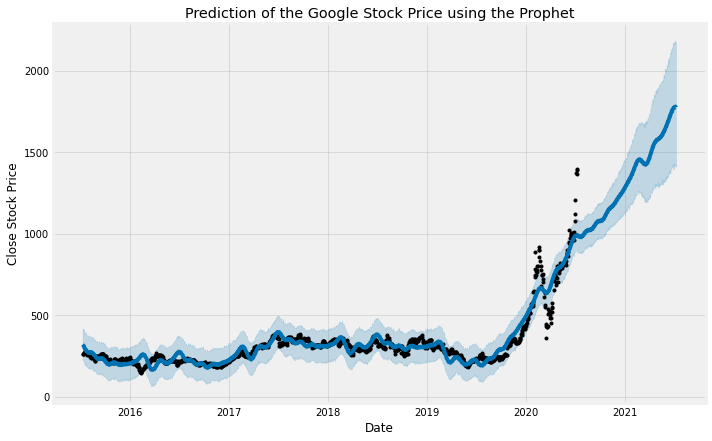

In [12]:
# 畫圖看結果
fig = model.plot(predictions) # 要加上 fig = 才不會畫兩張一模一樣的圖
plt.title("Prediction of the Google Stock Price using the Prophet")   
plt.xlabel("Date")   
plt.ylabel("Close Stock Price")   
plt.show()

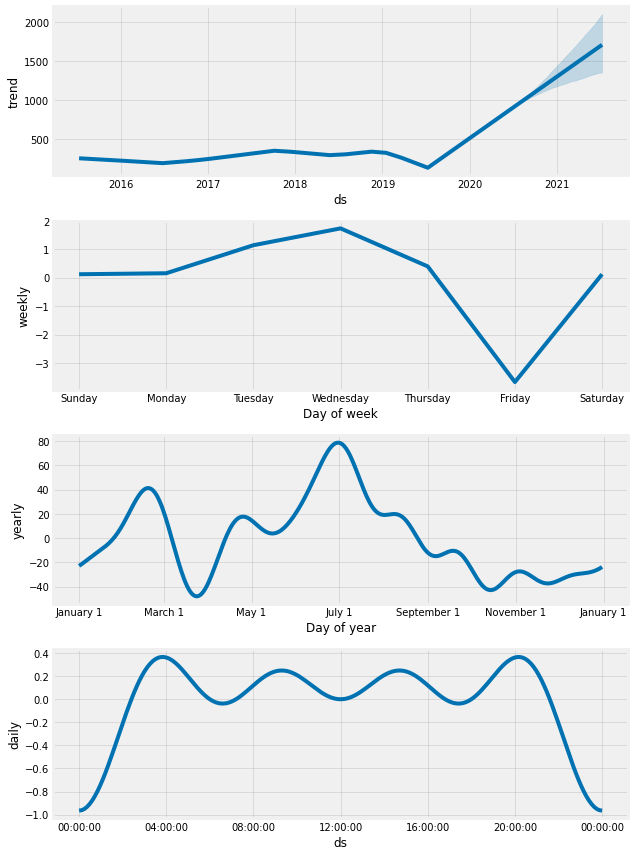

In [13]:
# 畫圖看 daily, weekly, yearly 的 trend
fig = model.plot_components(predictions)